<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks/03_LM_classification_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Documents

In this notebook, you'll learn about **Latent Dirichlet Allocation** (LDA) algorithm, and how to use it to cluster documents.

Key-learning:
- Unsupervised machine learning for NLP
- Clustering Documents
- LDA
- python packages: *pandas*, *gensim*

Terms in this notebook:
- Bag of words
- LDA
- Clustering
- TF/IDF

This notebook includes 2 recommended videos (total length: 25min).

Estimated reading duration: 1-2h.


# Setup

We start by importing [pandas](https://pandas.pydata.org/) - an essential tool for data scientists!

For this demonstration of the algorithm, we will use a corpus in the shape of a .CSV (Comma Seperated Values) file of German news articles from https://github.com/tblock/10kGNAD.

A CSV file is similar to an Excel file: it's a table of data, but is saved as a text file, and it's separated to fixed colums using a delimiter, such as a comma: ",".

In [1]:
from IPython.display import YouTubeVideo

In [2]:
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Pandas is a useful package to [load and parse CSV files](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). It can also parse TSV - separated by tabs, or as in our case, separated by a `;`.

Pandas is often used as the first-step for data scientists to load, analyze and even to proess and prepare the data.

In [3]:
articles_df = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv',
                 sep=';',
                 on_bad_lines='skip',
                 header=None,
                 names=['article_category', 'content'],   # this CSV contains 2 columns, which we are naming here
                 dtype={'article_category': 'category'})  # We hint here pandas that the article_category is of type "categorical column" (label-column)

Let's understand what is happenning in that command using Pandas' [API documentation](https://pandas.pydata.org/pandas-docs/stable/) for the method [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html):

- The first argument is the path or URL to the CSV file that we want to load. This is the only mandatory argument, while the rest are optional.
- The second argument tells pandas that our separator is actually ';', and not a comma (',').
- The third argument tells it to skip "bad" lines.
- the header argument hints pandas if the first line is the column titles
- the names argument supplies alternative names for each column
- the dtype argument allows us to determine the type of every column (int, float, string, categorical, etc.).

The Categorical dtype is a very useful type: It consumes less memory (RAM) for columns with repeated strings. It is especially useful for textual labels, since it allows converting these labels to numbers (0-k).

Let's take a peek at the dataframe we just loaded:

In [4]:
articles_df

,article_category,content
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,Mitarbeiter überreichten Eigentümervertretern ...
3,Etat,Service: Jobwechsel in der Kommunikationsbranc...
4,Etat,Was Sie über diese Woche wissen sollten - und ...
...,...,...
9571,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
9572,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
9573,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
9574,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


Our corpus contains 9 categories, as seen below.
However, we are going to brutally ignore them. Instead, we will use an unsupervised algorithm to deduct the topics only by the articles content, or in other words: we will *cluster* those documents based on their content.

In [5]:
articles_df['article_category'].cat.categories

Index(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web',
       'Wirtschaft', 'Wissenschaft'],
      dtype='object')

Therefore, we can safely drop the article_category column completely, and remain with the corpus text only:

In [6]:
articles_df = articles_df.drop('article_category', axis=1); articles_df

,content
0,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,App sei nicht so angenommen worden wie geplant...
2,Mitarbeiter überreichten Eigentümervertretern ...
3,Service: Jobwechsel in der Kommunikationsbranc...
4,Was Sie über diese Woche wissen sollten - und ...
...,...
9571,Die Fundstelle in Südengland ist Unesco-Weltku...
9572,Im Team arbeitet auch ein Inspektor der sudane...
9573,Die zentrale Frage des Projekts: Siedelten Ägy...
9574,Klimatische Verschlechterungen dürften zur Auf...


# Clustering with Latent Dirichlet Allocation (LDA)

## Introduction

We start by clustering our data as an unsupervised learning task: **topic modeling**.

There are many different methods to cluster documents. One of these methods is topic modeling - where an algorithm assigns a topic (or a list of most-related topics) to each document and clusters these documents by these topics.

Documents can be represented as a distribution of their words: their occurrences and frequencies. A set of words, which are relatively not frequent but are common to several documents, can express a document topic.
For example, suppose we locate documents with the words 'Android', 'OnePlus' and 'iPhone' in them. Based on the frequency of these words, we could assume that these documents are related to mobile phones.

[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a distribution on probability distributions. In other words, it can handle the frequency of which a set of words appear (which have by themselves, each one, a frequency).

For a deeper mathematical explanation of this distribution, watch this recommended video: https://www.youtube.com/watch?v=nfBNOWv1pgE

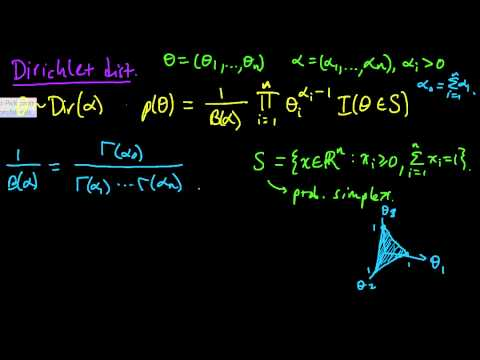

In [7]:
YouTubeVideo('nfBNOWv1pgE')

LDA is an unsupervised algorithm that assigns topics to every document. These topics are described as a set of words.
Each document can contain more than one topic.
For example, some article about Apple can be 80% mobile phones and 20% about business innovations or income.

LDA paper is a milestone in NLP and one of the recommended readings.

If you're interested to learn more about the algorithm method, watch this video: https://www.youtube.com/watch?v=DWJYZq_fQ2A.

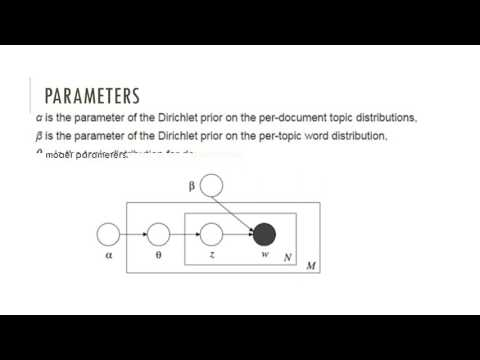

In [8]:
YouTubeVideo('DWJYZq_fQ2A')

Now, let's examine our German data set with LDA:

In the previous exercises, you got to know NLTK.

Here we will also use NLTK's methods of **stemming** the words. By returning to the root of the word, its stem, we reduce the dimensionality: the number of words in the vocabulary decreases. For example, instead of having different words for the singular and plural form - 'word' <--> 'words' or 'Kanzler', 'Kanzlers', 'Kanzlei', etc., we trim those words into 'Kanzl'. Hence we can reduce the size of the vocabulary by at least half.

We will also remove `stopwords` from our text. In English, words such as: `a`, `an`, and `the` will be removed, as they don't add much to the meaning of the sentence. For each language, there is a different curated list of such words, and NLTK is a great source for those.

In this exercise, you'll be introduced to another package, specialized in topic modeling, called `gensim`:
https://radimrehurek.com/gensim/



Lastly, remember that for every Machine Learning task, we must always consider:
> How are we going to test our model after training?

For classification, we use metrics such as [accuracy, precision, recall,](https://en.wikipedia.org/wiki/Accuracy_and_precision), [F1-Score](https://en.wikipedia.org/wiki/F-score), [MCC](https://towardsdatascience.com/matthews-correlation-coefficient-when-to-use-it-and-when-to-avoid-it-310b3c923f7e), etc.
For this topic-modeling task, we will use [perplexity](https://en.wikipedia.org/wiki/Perplexity).


In [9]:
!pip install -U gensim

We will define here two functions: `lemmatize_stemming` and `preprocess`.
`lemmatize_stemming` will use either lemmatization or stemming to reduce the vocabulary dimensionality.

`preprocess` will use the `lemmatize_stemming` function and process a list of tokens to prepare them as an input to our LDA model.

In [10]:
from pprint import pprint # for printing objects nicely

from gensim import corpora, models
from gensim.utils import simple_preprocess

# from gensim.parsing.preprocessing import STOPWORDS
# Instead of the gensim english stopwords, we use nltk's German stopwords
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import numpy as np

from random import choice

# fixing the randomization for reproducibility
np.random.seed(1234)

# loading the german stemming tool:
stemmer = SnowballStemmer('german')
german_stop_words = set(stopwords.words('german'))


def lemmatize_stemming(text: str):
  """
  Given a string, return the string lemattized using the german snowball stemmer
  """
  return stemmer.stem(text)

def preprocess(text: list[str]):
  """
  Preprocessing a list of tokens by removing stopwords and lemmatizing the tokens.
  Also, removing tokens which are shorter than 3 characters.
  """
  result = [lemmatize_stemming(token)
            for token in simple_preprocess(text)
            if token not in german_stop_words and len(token) > 3]
  return result


DataFrame is a table that contains the articles and their topics.

We only need the articles for this tasks - as we will create our own topics.

So, let's start by ditching the pandas dataframe through converting the articles column into a simple list of strings that contains all the articles:

In [11]:
all_articles = articles_df['content'].to_list()
all_articles[:5]

['Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinn

## Preprocessing

Let's see an example, what happens when we pre-process a document using the functions we previously created.

Look at the output of this cell, and compare the tokenized original document, to the lemmatized document:

In [12]:
print('original document: ')
article = choice(all_articles)
print(article)

# This time, we don't care about punctuations as tokens (Can you think why?):
print('original document, broken into words: ')
words = [word for word in article.split(' ')]
print(words)
print("Vocabulary size of the original article:", len(set(words)))

# now let's see what happens when we pass the article into our preprocessing
# method:
print('\n\n tokenized and lemmatized document: ')
preprocessed_article = preprocess(article)
print(preprocessed_article)
print("Vocabulary size after preprocessing:", len(set(preprocessed_article)))


original document: 
Im dritten Quartal stiegen Auslieferungen nach eigenen Angaben um 63 Prozent. Der chinesische Technologieriese Huawei wird heuer nach Einschätzung von Analysten das stärkste Wachstum im hart umkämpften Smartphone-Markt hinlegen. Allein im dritten Quartal stiegen die Auslieferungen des chinesischen Anbieters nach eigenen Angaben um 63 Prozent auf 27,4 Millionen Smartphones. Damit ist der Konzern auf Kurs, die Marke von 100 Millionen Stück im Gesamtjahr zu übertreffen. Das würde gegenüber 2014 einem Plus von einem Drittel entsprechen. Laut Analysten wird Huawei damit beim reinen Wachstum alle großen Anbieter wie Apple, Samsung, Lenovo oder Xiaomi hinter sich lassen. Trotzdem ist der Abstand zu den Platzhirschen Apple und Samsung noch immer groß. Huawei teilte am Dienstag auch mit, überdurchschnittlich hohe Zuwachsraten habe es vor allem im Heimatmarkt und in Europa gegeben. Außerdem würden mittlerweile mehr teure Modelle verkauft. Das ist ein wichtiger Baustein der Ch

Now let's pre-process all of the articles.

This is a heavy procedure, and may take a bit ;)

In [13]:
processed_docs = list(map(preprocess, all_articles))
# show the first 10 articles:
processed_docs[:10]

[['tocht',
  'degeto',
  'verpflichtet',
  'august',
  'quotenregel',
  'folg',
  'gleichstell',
  'regisseurinn',
  'sorg',
  'mindest',
  'prozent',
  'film',
  'tocht',
  'degeto',
  'produziert',
  'mitfinanziert',
  'soll',
  'mitt',
  'august',
  'frau',
  'regi',
  'fuhr',
  'degeto',
  'chefin',
  'christin',
  'strobl',
  'folgt',
  'forder',
  'quot',
  'regi',
  'verein',
  'regisseurinn',
  'vergang',
  'jahr',
  'quotenregel',
  'gefordert',
  'weiblich',
  'filmschaff',
  'mehr',
  'gehor',
  'okonom',
  'gleichstell',
  'verschaff',
  'quot',
  'regi',
  'kritisiert',
  'rund',
  'prozent',
  'regi',
  'studier',
  'weiblich',
  'seien',
  'anteil',
  'regisseurinn',
  'fernsehfilm',
  'prozent',
  'lieg',
  'osterreich',
  'sieht',
  'situation',
  'ahnlich',
  'seit',
  'handlungsbedarf',
  'angemahnt',
  'ausseh',
  'einfuhr',
  'quotenregel',
  'osterreich',
  'film',
  'sinnvoll',
  'diskuti',
  'forum'],
 ['angenomm',
  'word',
  'geplant',
  'weg',
  'gering',
  '

## Setting Up The Dictionary

Our preprocessing is complete.

We now need to calculate the occurance frequencies of each of our stemmed words. But first, we will create a vocabulary dictionary where every word appears once. Every article would be represented as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), an unordered set of words that the article contain.

---

Q: Why is it called bag-of-words?

Hint: Think about your probability lessons - where you had randomly picked out white or black balls out of a bag...

In [14]:
dictionary = corpora.Dictionary(processed_docs)

Let's take a look:

In [15]:
for idx, (key, val) in enumerate(dictionary.iteritems()):
    print(key, val)
    if idx >= 10:
        break


### Note: `enumerate` is a great python function!
### It creates an index, a running counter, for every object in the collection.
### read more about it here: https://realpython.com/python-enumerate/

0 ahnlich
1 angemahnt
2 anteil
3 august
4 ausseh
5 chefin
6 christin
7 degeto
8 diskuti
9 einfuhr
10 fernsehfilm


Second, we filter the tokens that may appear to often.

We have full control on the process.

### Model Hyperparameter tuning

#### Exercise 1:
Q: How would changing these parameters influence the result?

Please run these cells first.
After running this example, please return here to change them and test the result with different parameter values.

In [16]:
## Model hyper parameters:

## These are the dictionary preparation parameters:
filter_tokens_if_container_documents_are_less_than = 15
filter_tokens_if_appeared_percentage_more_than = 0.5
keep_the_first_n_tokens = 100_000

## and the LDA Parameters:
num_of_topics = 10

In [17]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens)


We now create a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) dictionary for each document, using [gensim's dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) tool.

It will be in the format of:

```{ 'word_id': count }```


In [18]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Let's take a look at the result.

Our corpus contains now only word_ids, not the words themselves, so we have to peek into the dictionary to know which word that id represents:

In [19]:
# randomly choose an article from the corpus:
sample_bow_doc = choice(bow_corpus)

print('The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:')
print(sample_bow_doc, '\n\n')

print ('We peek in the dictionary: for each word_id, we get its assigned word:')
for word_id, word_freq in sample_bow_doc:
  real_word = dictionary[word_id]
  print(f'Word {word_id} ("{real_word}") appears {word_freq} time.')


The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:
[(13, 1), (19, 6), (36, 1), (61, 1), (62, 2), (65, 1), (234, 1), (272, 1), (273, 2), (318, 1), (325, 2), (336, 2), (372, 1), (396, 1), (400, 2), (413, 1), (474, 2), (566, 1), (585, 1), (589, 2), (618, 1), (619, 1), (722, 1), (808, 1), (890, 1), (977, 2), (1019, 1), (1052, 1), (1068, 1), (1101, 1), (1141, 1), (1173, 1), (1174, 1), (1221, 1), (1351, 2), (1450, 1), (1507, 2), (1541, 1), (1559, 1), (1575, 1), (1736, 1), (1760, 1), (1801, 2), (1854, 1), (1931, 1), (1933, 1), (1947, 1), (1948, 1), (1959, 1), (2183, 1), (2298, 1), (2316, 1), (3373, 2), (3379, 1), (3445, 1), (3540, 1), (3592, 2), (3646, 1), (3667, 1), (3864, 1), (3901, 1), (4004, 3), (4184, 1), (4193, 1), (4428, 1), (4447, 1), (4463, 1), (5146, 1), (5499, 7), (5529, 3), (5531, 3), (5532, 3), (6139, 1), (6263, 1), (6309, 1), (6478, 1), (6808, 1), (6847, 1), (7602, 3), (8087, 1), (9099, 1), (9232, 1)] 


We peek in the dictionary: 

## LDA model using Bag-of-words

Let's start by applying the LDA model using the bag-of-words (Warning: this could take a while):

In [20]:
lda_model = models.LdaMulticore(bow_corpus,
                                num_topics=num_of_topics,
                                id2word=dictionary,
                                passes=5,
                                workers=2)

It is done!

Now we can observe which topics the model had extracted from the documents.

- *Topics* are made of sets of words and their distribution for that topic, representing their weight in that topic.
- Every document may be composed of multiple topics, with different weights representing the relation to each topics.

We will loop over the extracted topics and examine the words that construct them.

In [21]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')


Topic: 0 	 Words: 0.008*"polit" + 0.007*"sagt" + 0.007*"standard" + 0.006*"wien" + 0.006*"grun" + 0.005*"partei" + 0.005*"regier" + 0.005*"land" + 0.004*"wahl" + 0.004*"seit"
Topic: 1 	 Words: 0.032*"prozent" + 0.016*"osterreich" + 0.014*"jahr" + 0.007*"standard" + 0.007*"euro" + 0.006*"wenig" + 0.006*"hoh" + 0.006*"land" + 0.006*"wien" + 0.005*"zahl"
Topic: 2 	 Words: 0.021*"euro" + 0.013*"wien" + 0.010*"million" + 0.009*"jahr" + 0.007*"prozent" + 0.006*"unternehm" + 0.006*"neu" + 0.006*"osterreich" + 0.006*"rund" + 0.005*"seit"
Topic: 3 	 Words: 0.009*"jahr" + 0.006*"erst" + 0.006*"gross" + 0.006*"wien" + 0.005*"schon" + 0.004*"spiel" + 0.004*"imm" + 0.004*"sagt" + 0.004*"neu" + 0.004*"lang"
Topic: 4 	 Words: 0.009*"erst" + 0.007*"spiel" + 0.007*"forsch" + 0.005*"salzburg" + 0.005*"wien" + 0.004*"jahr" + 0.004*"zwei" + 0.004*"konnt" + 0.004*"gross" + 0.004*"rapid"
Topic: 5 	 Words: 0.010*"neu" + 0.006*"sagt" + 0.006*"griechenland" + 0.005*"nutz" + 0.005*"soll" + 0.004*"appl" + 0.004*

## TF / IDF

Let's take it one step further. We will cluster our document by running the LDA using [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) instead of just the BoW.

We start with TF/IDF calculation on our bag-of-words.
TF/IDF accepts a dictionary of word frequencies as an input, and it calculates the term frequency and the inversed document frequency accordingly.

Its output is a re-weighted dictionary of the documents term frequencies:

In [22]:
# initialize a tfidf from our corpus
tfidf = models.TfidfModel(bow_corpus)

# apply it on our corpus
tfidf_corpus = tfidf[bow_corpus]

pprint(tfidf_corpus[0][:10])

[(0, 0.07624324224596976),
 (1, 0.09765147703315807),
 (2, 0.17806134714371552),
 (3, 0.12554321379384176),
 (4, 0.12114843374003081),
 (5, 0.14917128474504127),
 (6, 0.11948454964321391),
 (7, 0.10815383759404282),
 (8, 0.19221567840914694),
 (9, 0.0625612949812136)]


In [23]:
# the new tfidf corpus is just our corpus - but transformed. It has the same size of documents:
assert len(bow_corpus) == len(tfidf_corpus)

Now let's apply LDA on the tfidf corpus, with the same amount of topics.

You can play with the # of passes, if the model doesn't converge properly

In [24]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus,
                                      num_topics=num_of_topics,
                                      id2word=dictionary,
                                      passes=10,
                                      workers=4)

In [25]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.007*"prozent" + 0.005*"zielpunkt" + 0.005*"volkswag" + 0.004*"euro" + 0.003*"unternehm" + 0.003*"dollar" + 0.003*"million" + 0.003*"pfeiff" + 0.003*"notenbank" + 0.003*"minus"
Topic: 1 	 Word: 0.003*"euro" + 0.003*"mannch" + 0.002*"china" + 0.002*"million" + 0.002*"prozent" + 0.002*"milliard" + 0.002*"tonn" + 0.002*"airbus" + 0.002*"konz" + 0.002*"europa"
Topic: 2 	 Word: 0.004*"griechenland" + 0.004*"griechisch" + 0.004*"fluchtling" + 0.003*"regier" + 0.003*"ath" + 0.003*"word" + 0.002*"polizei" + 0.002*"finanzminist" + 0.002*"land" + 0.002*"tsipras"
Topic: 3 	 Word: 0.029*"volltext" + 0.027*"basier" + 0.024*"artikel" + 0.021*"rechtlich" + 0.018*"verfug" + 0.015*"grund" + 0.014*"steht" + 0.004*"teilch" + 0.003*"physik" + 0.003*"akti"
Topic: 4 	 Word: 0.004*"prozent" + 0.004*"euro" + 0.003*"milliard" + 0.002*"rousseff" + 0.002*"dollar" + 0.002*"astronaut" + 0.002*"unternehm" + 0.002*"rapid" + 0.002*"umsatz" + 0.002*"million"
Topic: 5 	 Word: 0.006*"prozent" + 0.005*"

## Inference

Now that we have a topic-modeler, let's use it on one of the articles.

In [26]:
# randomly pick an article:
test_doc = choice(range(len(processed_docs)))
processed_docs[test_doc][:50]

['beim',
 'entfern',
 'pickerl',
 'hatt',
 'betroff',
 'schwer',
 'verletz',
 'wien',
 'wien',
 'berufsschul',
 'montag',
 'aufkleb',
 'rechtsradikal',
 'identitar',
 'beweg',
 'osterreich',
 'vier',
 'rasierkling',
 'gefund',
 'word',
 'aufkleb',
 'entfern',
 'hatt',
 'schwer',
 'zuzieh',
 'sagt',
 'direktorin',
 'monika',
 'gojkovic',
 'vojnovic',
 'verletzt',
 'wurd',
 'niemand',
 'schul',
 'verstandigt',
 'polizei',
 'erstattet',
 'anzeig',
 'bild',
 'aufkleb',
 'kursiert',
 'montag',
 'sozial',
 'medi',
 'rasierkling',
 'identitar',
 'stick',
 'schul',
 'https',
 'antifa']

Using the original BOW model:

In [27]:
for index, score in sorted(lda_model[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print(f"Topic match score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")


Topic match score: 0.9849841594696045 
Topic: 0.010*"word" + 0.010*"jahr" + 0.009*"sagt" + 0.008*"jahrig" + 0.007*"polizei" + 0.007*"mann" + 0.006*"weg" + 0.006*"wien" + 0.006*"frau" + 0.005*"zwei"


And with the TF/IDF model:

In [28]:
for index, score in sorted(lda_model_tfidf[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print("Topic match score: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))

Topic match score: 0.5107717514038086	 
Topic: 0.002*"prozent" + 0.002*"osterreich" + 0.002*"wien" + 0.002*"euro" + 0.002*"jahr" + 0.002*"forsch" + 0.002*"standard" + 0.002*"neu" + 0.001*"million" + 0.001*"gross"
Topic match score: 0.47588062286376953	 
Topic: 0.004*"griechenland" + 0.004*"griechisch" + 0.004*"fluchtling" + 0.003*"regier" + 0.003*"ath" + 0.003*"word" + 0.002*"polizei" + 0.002*"finanzminist" + 0.002*"land" + 0.002*"tsipras"


Calculating the [perplexity score](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94) (lower is better):

In [29]:
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))
print('Perplexity TFIDF: ', lda_model_tfidf.log_perplexity(bow_corpus))

Perplexity:  -7.997365981435226
Perplexity TFIDF:  -8.402540144666993


### Exercise - inference

Now try it on a new document!

Go to a news website, such as [orf.at](https://orf.at/) and copy an article of your choice here:

In [30]:
unseen_document = """Sobotka sprach in einer um eineinhalb Stunden verspäteten Pressekonferenz am Abend von einer „schwierigen“, aber „sachlichen und pointierten“ Diskussion im Hauptausschuss. Er meinte, dass von Gesundheitsminister Rudolf Anschober (Grüne), die „Notwendigkeit, Verhältnismäßigkeit und Richtigkeit“ der Maßnahmen erläutert worden seien. Zudem betonte Sobotka die Wichtigkeit der im Covid-Maßnahmengesetz vorgesehenen Mitsprache des Parlaments bei Maßnahmen, bei denen auch die Freiheitsrechte betroffen seien.
Der Nationalratspräsident zitierte auch die deutsche Kanzlerin Angela Merkel, die die Maßnahmen im Kampf gegen die Pandemie als „demokratische Zumutung“ bezeichnet hatte. Dem sei nicht nur zuzustimmen, das sei auch zu unterstreichen, sagte er. Die Eindämmung der Pandemie könne aber nur gelingen, wenn sich alle Österreicher einbringen. Der Beschluss alleine reiche nicht, die Maßnahmen müssten auch im Geiste verinnerlicht werden, appellierte Sobotka an die Bevölkerung, die Maßnahmen mitzutragen.
Rendi-Wagner kritisiert Regierung
Die Opposition hatte schon vor der Sitzung – und dann auch noch einmal danach – ihre Kritik an der Regierung bekräftigt. „Die Bundesregierung hat die Kontrolle über das Infektionsgeschehen verloren und hat die schwierige Situation, vor der wir jetzt stehen, zu verantworten“, kritisierte SPÖ-Klub- und Parteivorsitzende Rendi-Wagner.
Sessel auf Tischen in einem geschlossenen Lokal
DEBATTEWie gerechtfertigt sind die Maßnahmen?"""

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("Simply printing the lda_model output would look like this:")
pprint(lda_model[bow_vector])

print("\n\nSo let's make it nicer, by printing the topic contents:")
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print(f"Score: {score}\t Topic: {lda_model.print_topic(index, 5)}")


Simply printing the lda_model output would look like this:
[(0, 0.9890107)]


So let's make it nicer, by printing the topic contents:
Score: 0.9890106916427612	 Topic: 0.008*"polit" + 0.007*"sagt" + 0.007*"standard" + 0.006*"wien" + 0.006*"grun"


## Visualization

Finally, there are packages that can visulaize the results, such as [pyLDAvis](https://pypi.org/project/pyLDAvis/) and [tmplot](https://pypi.org/project/tmplot/). Here's what it looks like:

In [31]:
!pip install pyLDAvis

In [32]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

bow_lda_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

pyLDAvis.display(bow_lda_data)

# Exercise - Your turn:

Find another corpus to cluster its topic with LDA. Preferably the corpus should be in another language (maybe your own native language?). Your corpus can contain text only, without any categories. It can contain texts in any length: documents, books, comments or product reviews, tweets, etc.

There are many corpus online for free use. Here are some example websites that offer lists of corpora:
- https://www.corpusdata.org/intro.asp
- here: https://www.clarin.eu/resource-families/newspaper-corpora
- NLTK offers many corpora: https://www.nltk.org/nltk_data/
- In this github repository, there are many datasets that can be loaded through their `raw` url: https://github.com/selva86/datasets

Careful: You may need to change the [Stemming](https://snowballstem.org/algorithms/) and the [Stopwords](https://www.kaggle.com/rtatman/stopword-lists-for-19-languages) to support your corpus language. Make a web-search to find an appropriate ones.

The delivery should be a notebook or code that parse the corpus into topics using LDA, preferably vectorized with TF/IDF. You can use the LDA code here as guideline.

Try detecting which *num_of_topics* fits most for your corpus, by changing the hyperparameters to get a *satisfying level of clustering*.

Please summarize which parameters worked best for the corpus you chose.

##### Help note: About loading and reading files in Python

If your corpus is a csv, [pandas' read_csv method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) would be the best way to tackle it.

If it is, however a text file or a zip of text files, you will need another way to load them. Luckily, python is working well with both - text and zip files, with a built-in support.

For the sake of this example, let's download two files: one text file, and one gzip file, from this website:

https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-6260-A

In [ ]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A{/README.txt,/hindmonocorp05.plaintext.gz}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4472  100  4472    0     0   4614      0 --:--:-- --:--:-- --:--:--  4619
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 77 2353M   77 1812M    0     0  27.3M      0  0:01:26  0:01:06  0:00:20 24.9M

Files are accessed using the `Path` package of python's pathlib:

In [ ]:
from pathlib import Path

To access a file, we use its path in Path, like so:

`Path('Folder/filename.extension')`

Path has many methods for files and folder. Including looping over files in folder, checking if a file exists, etc.

Read more about it here: https://docs.python.org/3/library/pathlib.html

In [ ]:
readme_file = Path('README.txt')

if readme_file.exists():
  # read the text content into a variable
  file_content = readme_file.read_text()
  print(file_content)
else:
  print("README.txt was not found...")

If the file is a `.zip` file, you can open it and read its data without actually extracting all the files from it.

https://docs.python.org/3/library/gzip.html

Also, [requests](https://requests.readthedocs.io/en/latest/) is a great package of retrieving content from a URL.

In [ ]:
import gzip


In [ ]:

# this would download the file (but it's 2 GB, and we've already downloaded it before...):
# file = requests.get('https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A/hindmonocorp05.plaintext.gz')
# with gzip.open(file.content, 'rb') as gz:
#  ...

In this example, we will open the zip and read the text lines.
The text is in hindi, so we have to decode it into `UTF-8` format:

In [ ]:
with gzip.open('hindmonocorp05.plaintext.gz', 'rb') as gz:
  for i in range(10):
    line = gz.readline()
    words = line.decode('utf8').split()
    print(words)


**IMPORTANT NOTE**: If your corpuse, like that file example is very large (2.3GB zipped), then please don't load all the text, it will not fit in the memory and will only cause you trouble. Instead, you can just use the first 10 to 20k sentences, or so. For this exercise we just want you to get a hold of the steps and the proces involved in using LDA.

# Afterword

Gensim is not the only library that implements the LDA algorithm.
Another package that does LDA is [tomotopy](https://bab2min.github.io/tomotopy/v0.12.3/en/) - sometimes even faster than gensim. Additionaly, it is implemented as part of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) - which we use often in the course.

Here's a jupyter example using Scikit-learn and spaCy: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

Since we won't dive deeper into the LDA topic in this course, if you wish to know more about the statistics behind it, [this video](https://www.youtube.com/watch?v=0jQo8lVRHRY) of a lesson by the researcher [Nando de Freitas](https://linkedin.com/in/nandodefreitas) gives a good overview.